In [1]:
using QuantumCollocation
using NamedTrajectories
using Optim
using TrajectoryIndexingUtils
using LinearAlgebra
using CairoMakie
using JLD2
using Revise
using ForwardDiff
using Distributions
using Plots

includet("../SVD_RL_Methods.jl")

In [2]:
const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units
;

In [3]:
# Operators
const Paulis = Dict(
    "I" => Matrix{ComplexF64}([1 0; 0 1]),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 -im; im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)

Dict{String, Matrix{ComplexF64}} with 4 entries:
  "Y" => [0.0+0.0im 0.0-1.0im; 0.0+1.0im 0.0+0.0im]
  "Z" => [1.0+0.0im 0.0+0.0im; 0.0+0.0im -1.0+0.0im]
  "I" => [1.0+0.0im 0.0+0.0im; 0.0+0.0im 1.0+0.0im]
  "X" => [0.0+0.0im 1.0+0.0im; 1.0+0.0im 0.0+0.0im]

In [4]:
G = exp(-im/2 *π*(kron(Paulis["Y"],Paulis["X"])+kron(Paulis["X"],Paulis["Y"])))
H_drives = [
    kron(Paulis["X"],Paulis["I"]),kron(Paulis["Y"],Paulis["I"]),
    kron(Paulis["I"],Paulis["X"]),kron(Paulis["I"],Paulis["Y"]),
    (kron(Paulis["X"],Paulis["X"])+kron(Paulis["Y"],Paulis["Y"]))/2
]
system = QuantumSystem(H_drives);
t_f = 15* ns
n_steps = 51
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
n_controls=1
n_qubits=1;
Δt = times[2] - times[1]

0.3

In [5]:
### Generate Initial Trajectories 
PICO_max_iter = 500

# Shape the cost function with weights on states and controls
Q = 100.
R =1e-2

a_bound = 1.0
dda_bound = 1.0

ops = IpoptOptions()
ops.print_info_string = "yes"
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1.0 ##down
ops.print_level = 0

p_op = PiccoloOptions()
p_op.verbose=false
p_op.pade_order=10
p_op.free_time=true
p_op.timesteps_all_equal=true

true

In [6]:
p  =UnitarySmoothPulseProblem(
    system,
    G,
    n_steps,
    Δt;
    ipopt_options = ops,
    piccolo_options=p_op,
    a_bound=a_bound,
    dda_bound=dda_bound,
    Q=Q,
    R=R,
)
solve!(p,max_iter=500)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [7]:
p_time = UnitaryMinimumTimeProblem(
    p;
)
solve!(p_time,max_iter=500)

In [8]:
Δt =  p_time.trajectory[:Δt][1] 

0.1500007442469032

In [9]:
a  = p_time.trajectory[:a]
dda  = p_time.trajectory[:dda]
data = accel_SVD_rollout(dda,system,n_steps,Δt)

32-element Vector{Matrix{Float64}}:
 [0.0 -5.441515360640138e-11 … -2.0583089963201286e-11 1.9710163033490113e-25; 0.0 7.48368843339047e-10 … 7.498929374100984e-10 -2.895132143935597e-24; … ; 0.0 -0.00242666292791056 … -0.005631578335910243 4.336808689942018e-18; 0.0 -2.0548884172171855e-8 … -1.185913056005842e-8 -3.4576149604716557e-22]
 [0.0 -0.0051847392927227435 … -0.0019714088467861265 2.3418766925686896e-17; 0.0 0.07121535460265882 … 0.07136052458385239 -1.942890293094024e-16; … ; 0.0 2.5368252418526437e-11 … 5.900388980578319e-11 -1.0339757656912846e-25; 0.0 3.896935089849337e-9 … -4.024519002777849e-9 -2.481541837659083e-23]
 [0.0 -0.068339548837379 … -0.06730625842866188 4.0245584642661925e-16; 0.0 0.006728340845816342 … -0.013550659524190801 -5.0306980803327406e-17; … ; 0.0 4.875173890202304e-10 … 4.951983005834128e-10 -5.0664812518872945e-24; 0.0 1.461109251266902e-8 … 7.427026123865631e-9 -1.0422475718168149e-22]
 [0.0 -4.948710358574625e-10 … -4.874547522231878e-10 1.13737

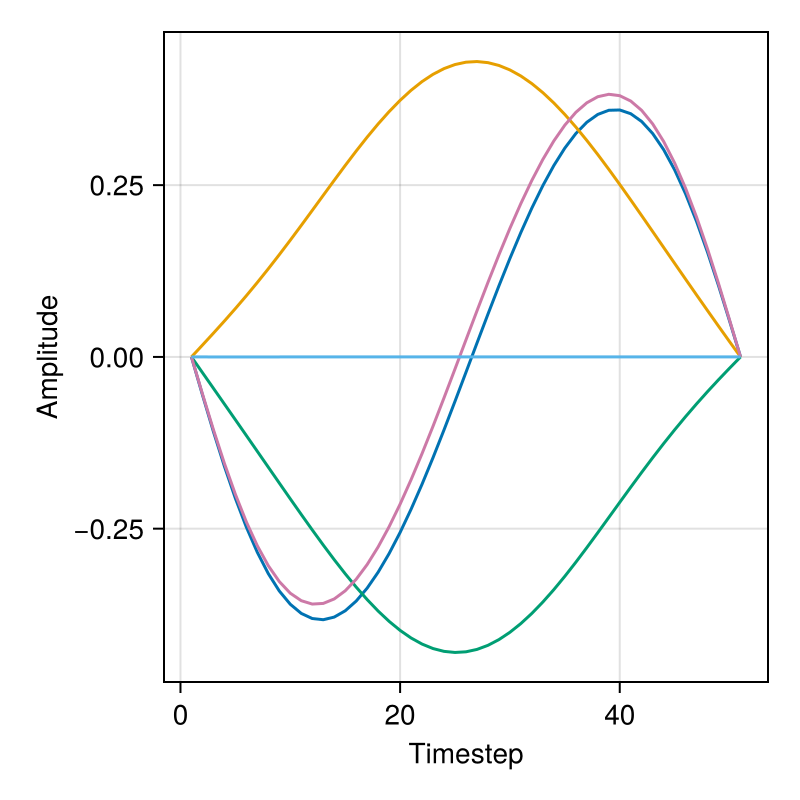

In [10]:
plot_data([a];figsize =(400,400))

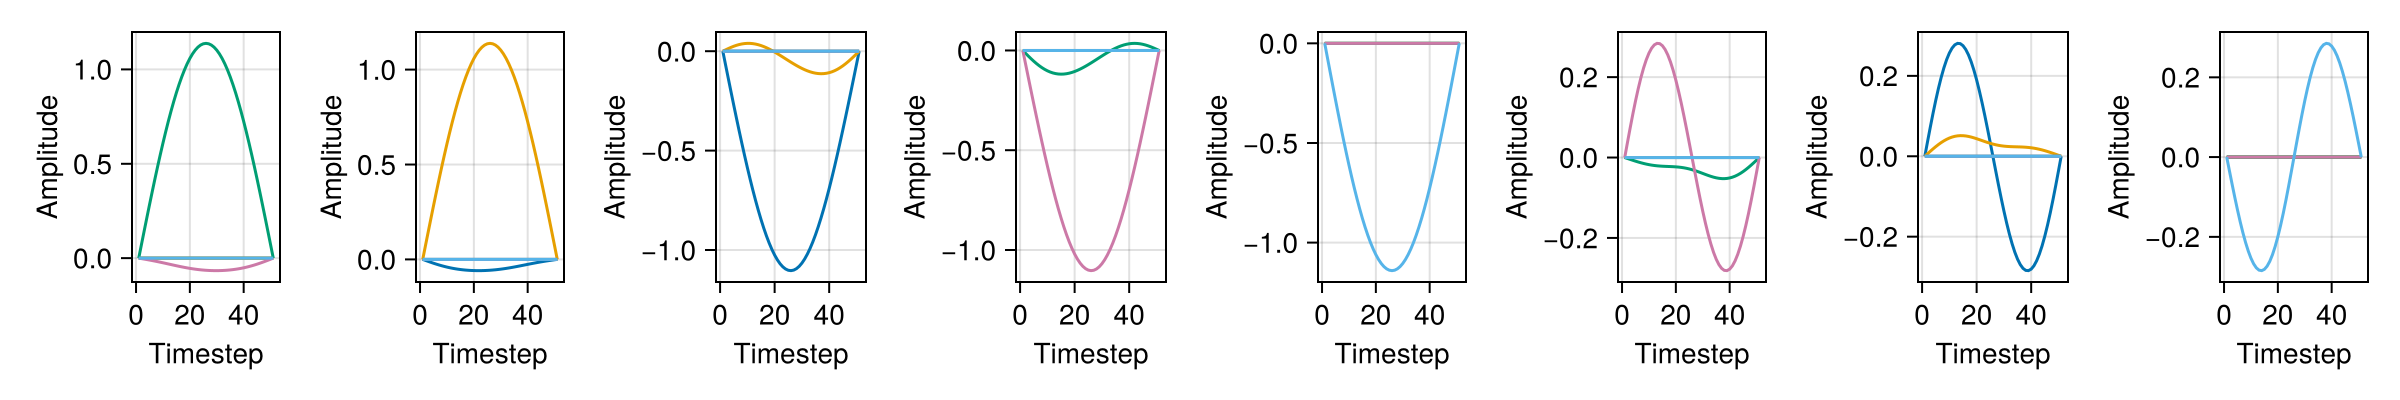

In [11]:
plot_data(data[1:8];figsize=(1200,200))

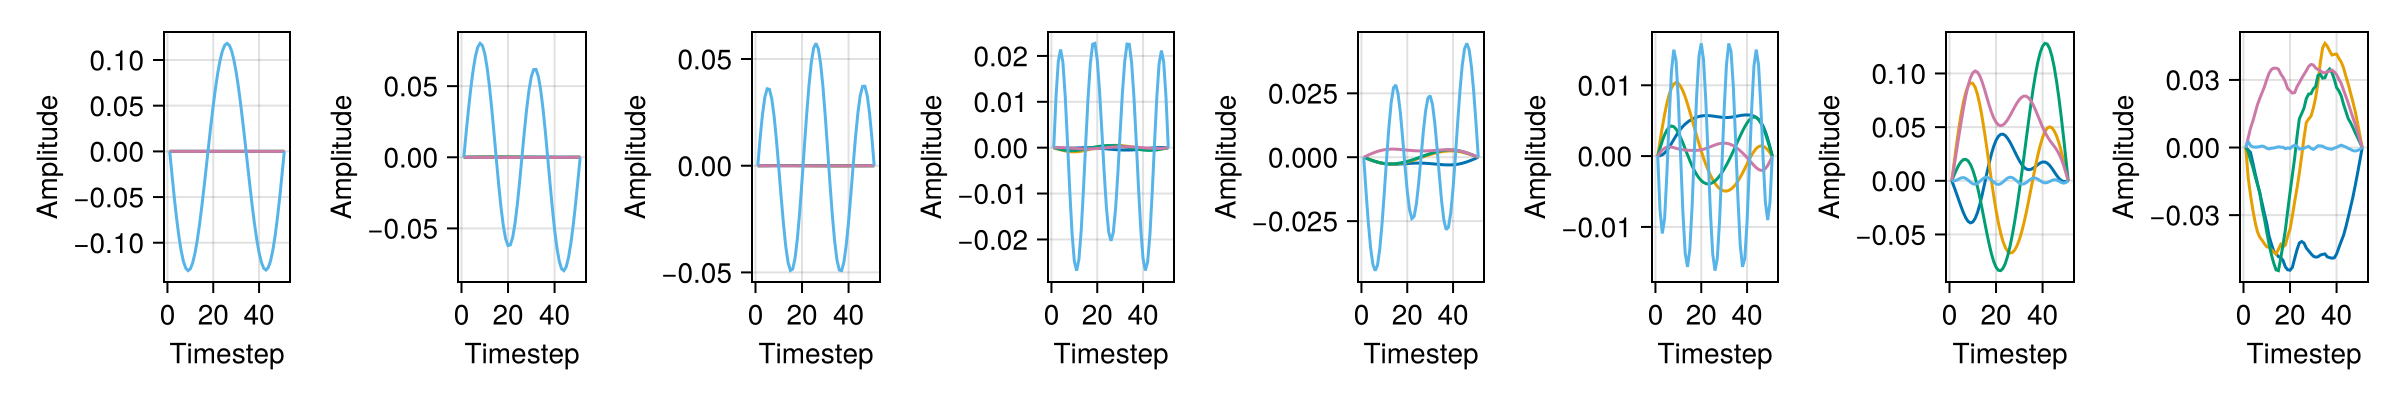

In [12]:
plot_data(data[9:16];figsize=(1200,200))

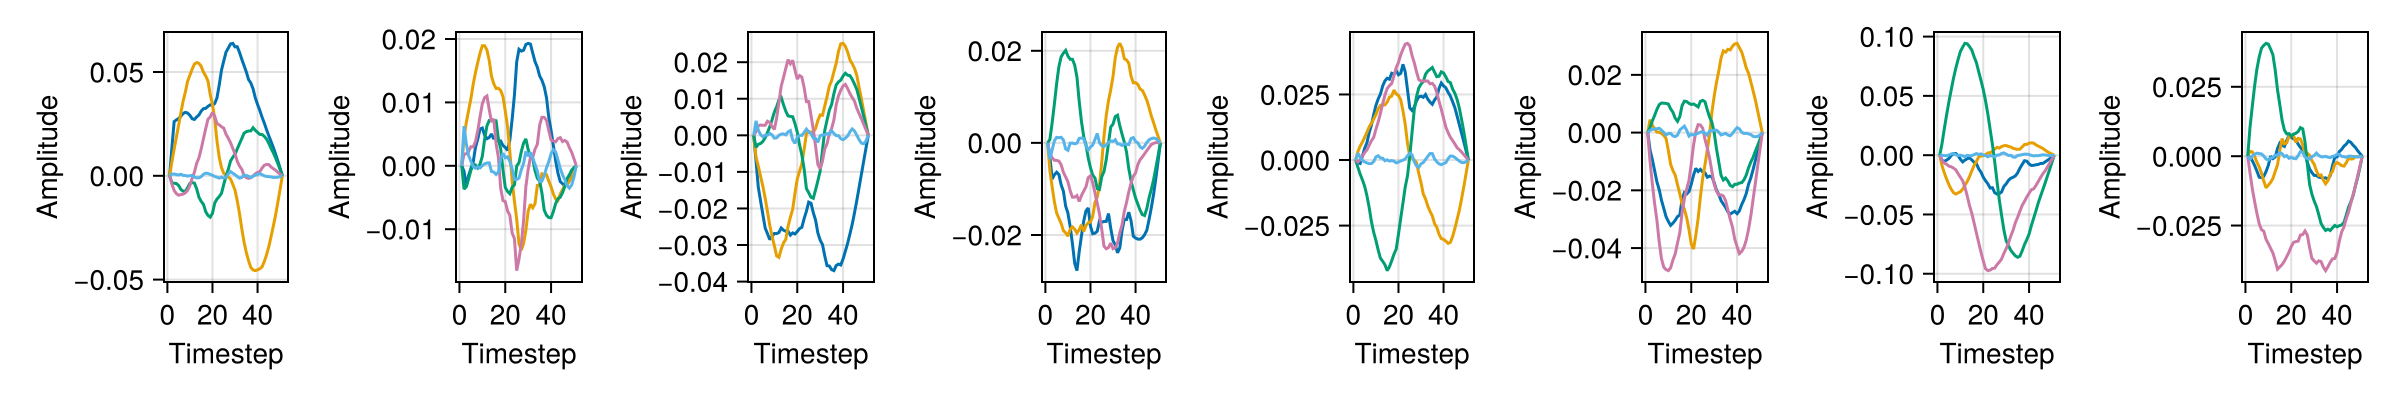

In [13]:
plot_data(data[17:24];figsize=(1200,200))

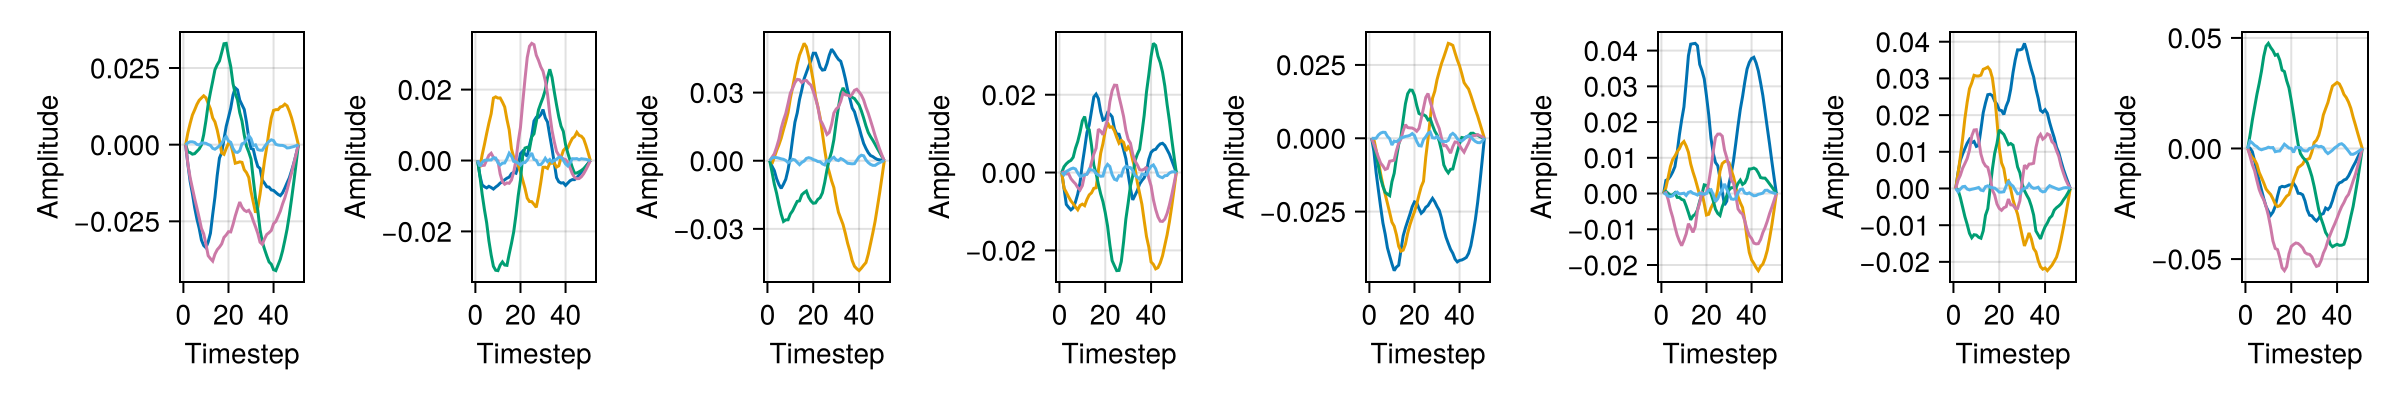

In [14]:
plot_data(data[25:32];figsize=(1200,200))

In [19]:
ϵ1 = 0.05
history1 = []
for i ∈ 1:20
    ϵ = rand(Uniform(-ϵ1,ϵ1),length(system.H_drives))
    system2 = perturb_system(system,ϵ)
    push!(history1,neadler_mead_opt(16,a,data,system2, n_steps,Δt,G;iterations=3000)[1])
end

In [20]:
ϵ2 = 0.15
history2 = []
for i ∈ 1:20
    ϵ = rand(Uniform(-ϵ2,ϵ2),length(system.H_drives))
    system2 = perturb_system(system,ϵ)
    push!(history2,neadler_mead_opt(16,a,data,system2, n_steps,Δt,G;iterations=3000)[1])
end

In [21]:
ϵ3 = 0.25
history3 = []
for i ∈ 1:20
    ϵ = rand(Uniform(-ϵ3,ϵ3),length(system.H_drives))
    system2 = perturb_system(system,ϵ)
    push!(history3,neadler_mead_opt(16,a,data,system2, n_steps,Δt,G;iterations=3000)[1])
end

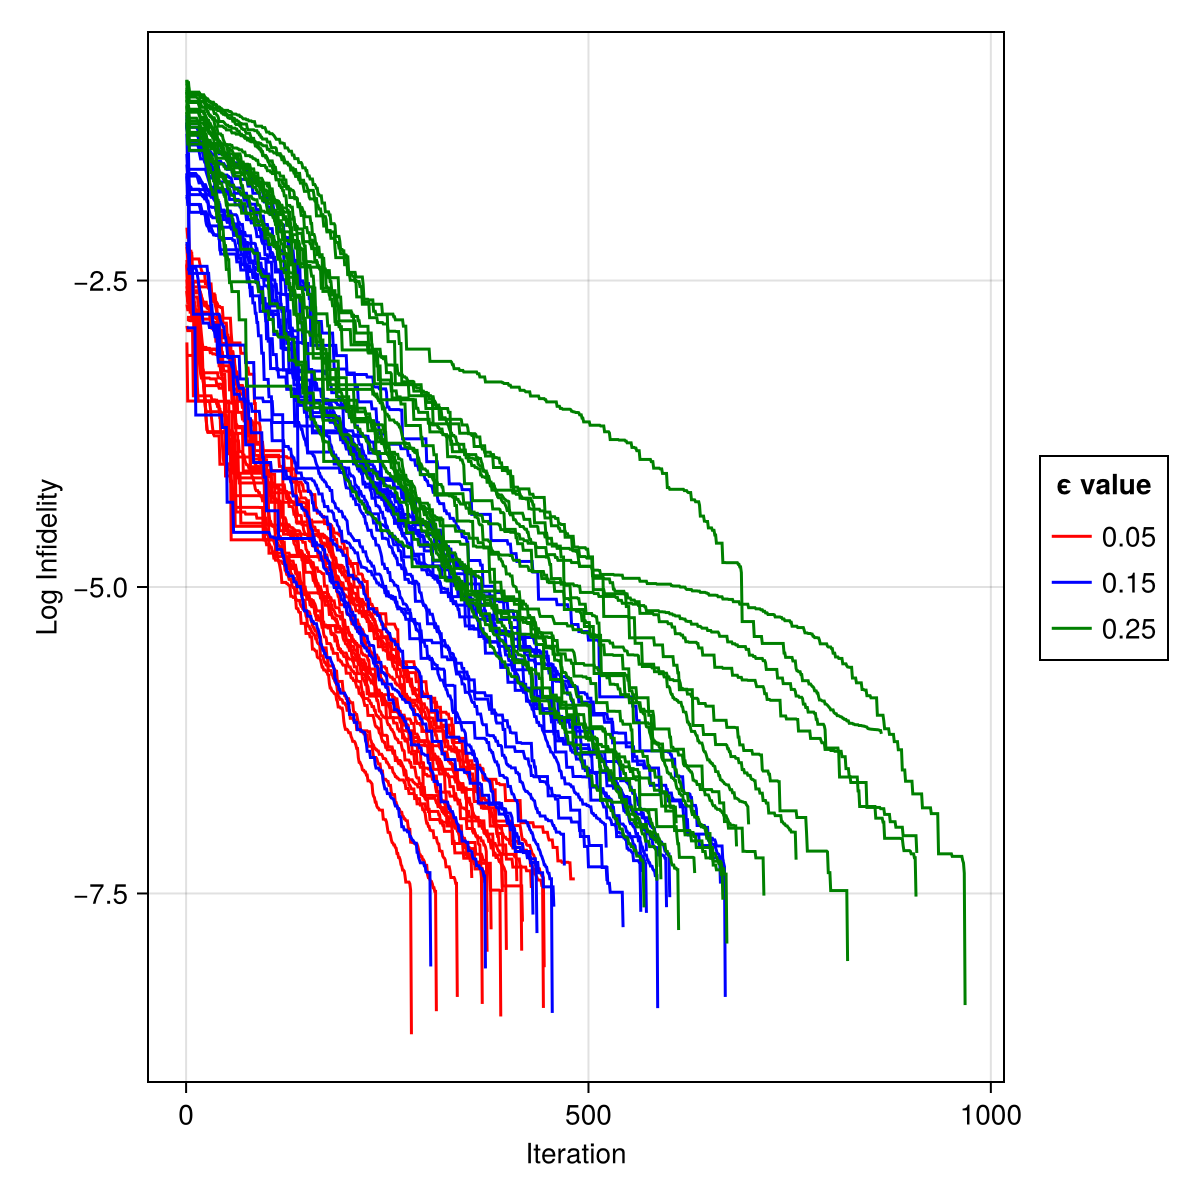

In [33]:
f = Figure(size =(600,600))
ax = Axis(f[1, 1],xlabel="Iteration",ylabel="Log Infidelity")
r=nothing
b=nothing
g=nothing
for (idx,h) ∈ enumerate(history1)
    r = lines!(log10.(h),label=string(idx),color=:red)
end

for (idx,h) ∈ enumerate(history2)
    g = lines!(log10.(h),label=string(idx),color=:blue)
end

for (idx,h) ∈ enumerate(history3)
    b = lines!(log10.(h),label=string(idx),color=:green)
end
Legend(f[1, 2],
    [r, g,b],
    ["0.05","0.15","0.25"],
    "ϵ" * " value")

f